In [45]:
import pandas as pd
import cupy as cp
from cupy import diff

def calculate_skew_kurt(window):
    """Manual calculation of skewness and kurtosis using CuPy"""
    # Ensure float32 for GPU efficiency
    window = window.astype(cp.float32)
    
    # Calculate moments
    mean = cp.mean(window, axis=0)
    std = cp.std(window, axis=0, ddof=0)
    diffs = window - mean
    
    # Avoid division by zero
    std += cp.where(std == 0, 1e-8, 0)
    
    # Standardized values
    z = diffs / std
    
    # Calculate skewness and kurtosis
    skew = cp.mean(z**3, axis=0)
    kurt = cp.mean(z**4, axis=0) - 3  # Fisher's definition
    
    return skew, kurt

def extract_time_features(window, eeg_columns):
    """GPU-accelerated feature extraction with manual skew/kurtosis"""
    features = {}
    
    # Basic stats
    features.update({
        f'{col}_mean': val for col, val in zip(
            eeg_columns, cp.mean(window, axis=0).get().tolist())
    })
    features.update({
        f'{col}_std': val for col, val in zip(
            eeg_columns, cp.std(window, axis=0).get().tolist())
    })
    features.update({
        f'{col}_var': val for col, val in zip(
            eeg_columns, cp.var(window, axis=0).get().tolist())
    })
    
    # Signal characteristics
    features.update({
        f'{col}_max': val for col, val in zip(
            eeg_columns, cp.max(window, axis=0).get().tolist())
    })
    features.update({
        f'{col}_min': val for col, val in zip(
            eeg_columns, cp.min(window, axis=0).get().tolist())
    })
    features.update({
        f'{col}_ptp': val for col, val in zip(
            eeg_columns, cp.ptp(window, axis=0).get().tolist())
    })
    
    # Manual skew/kurt calculation
    skew_vals, kurt_vals = calculate_skew_kurt(window)
    features.update({
        f'{col}_skew': val for col, val in zip(eeg_columns, skew_vals.get().tolist())
    })
    features.update({
        f'{col}_kurt': val for col, val in zip(eeg_columns, kurt_vals.get().tolist())
    })
    
    # Zero-crossing
    sign_changes = diff((window >= 0).astype(int), axis=0)
    features.update({
        f'{col}_zcross': val for col, val in zip(
            eeg_columns, cp.sum(sign_changes != 0, axis=0).get().tolist())
    })
    
    # Energy features
    features.update({
        f'{col}_energy': val for col, val in zip(
            eeg_columns, cp.sum(window**2, axis=0).get().tolist())
    })
    features.update({
        f'{col}_rms': val for col, val in zip(
            eeg_columns, cp.sqrt(cp.mean(window**2, axis=0)).get().tolist())
    })
    
    return features

# Rest of the code remains the same as previous version...

def sliding_window_features(eeg_data, outcomes, eeg_columns, window_size, step_size):
    """GPU-accelerated sliding window feature extraction with target alignment."""
    features_list = []
    targets = []
    n_samples = eeg_data.shape[0]
    
    for start in range(0, n_samples - window_size + 1, step_size):
        end = start + window_size
        window = eeg_data[start:end]
        outcome_window = outcomes[start:end]
        
        features = extract_time_features(window, eeg_columns)
        features_list.append(features)
        
        # Determine window target (modify based on your use case)
        targets.append(1 if cp.any(outcome_window) else 0)
    
    return features_list, targets

# Main processing
if __name__ == "__main__":
    # Load data with proper dtype specification
    data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\chbmit_preprocessed_data.csv')
    eeg_columns = [col for col in data.columns if col != 'Outcome']
    
    # Convert to CuPy arrays with float32 precision
    eeg_data = cp.asarray(data[eeg_columns].values, dtype=cp.float32)
    outcomes = cp.asarray(data['Outcome'].values, dtype=cp.float32)
    
    # Window parameters
    fs = 256  # Sampling frequency
    window_size = fs * 1  # 1-second windows
    step_size = window_size // 2  # 50% overlap
    
    # Process data on GPU
    features, targets = sliding_window_features(
        eeg_data, outcomes, eeg_columns, window_size, step_size
    )
    
    # Convert to DataFrame and save
    features_df = pd.DataFrame(features)
    features_df['target'] = targets
    features_df.to_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv', index=False)
    print("Feature extraction complete. Features saved to 'eeg_features_gpu.csv'")

Feature extraction complete. Features saved to 'eeg_features_gpu.csv'


In [26]:
original=pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\chbmit_preprocessed_data.csv')
features=pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv')

In [25]:
original.shape

(2097150, 24)

In [27]:
features.shape

(16382, 254)

In [28]:
original.head()

,# FP1-F7,C3-P3,C4-P4,CZ-PZ,F3-C3,F4-C4,F7-T7,F8-T8,FP1-F3,FP2-F4,...,P3-O1,P4-O2,P7-O1,P7-T7,P8-O2,T7-FT9,T7-P7,T8-P8-0,T8-P8-1,Outcome
0,0.000020,0.000010,0.000022,0.000037,0.000032,0.000035,0.000016,0.000046,-0.000007,0.000043,...,0.000024,-0.000030,0.000010,-0.000011,-0.000037,0.000008,0.000012,0.000021,0.000021,0.0
1,0.000022,0.000008,0.000021,0.000039,0.000030,0.000032,0.000015,0.000039,-0.000006,0.000042,...,0.000026,-0.000017,0.000012,-0.000008,-0.000029,0.000010,0.000009,0.000023,0.000023,0.0
2,0.000021,0.000012,0.000021,0.000040,0.000025,0.000030,0.000013,0.000036,-0.000006,0.000040,...,0.000027,-0.000018,0.000014,-0.000009,-0.000034,0.000012,0.000009,0.000027,0.000027,0.0
3,0.000019,0.000012,0.000021,0.000039,0.000023,0.000028,0.000013,0.000035,-0.000008,0.000036,...,0.000030,-0.000024,0.000015,-0.000009,-0.000042,0.000009,0.000010,0.000033,0.000033,0.0
4,0.000019,0.000012,0.000021,0.000036,0.000023,0.000024,0.000012,0.000024,-0.000009,0.000032,...,0.000032,-0.000014,0.000017,-0.000008,-0.000031,0.000009,0.000008,0.000035,0.000035,0.0


In [29]:
features.head()

,# FP1-F7_mean,C3-P3_mean,C4-P4_mean,CZ-PZ_mean,F3-C3_mean,F4-C4_mean,F7-T7_mean,F8-T8_mean,FP1-F3_mean,FP2-F4_mean,...,P3-O1_rms,P4-O2_rms,P7-O1_rms,P7-T7_rms,P8-O2_rms,T7-FT9_rms,T7-P7_rms,T8-P8-0_rms,T8-P8-1_rms,outcome
0,-5.556852e-06,2.430477e-06,0.000007,2.915313e-07,3.907875e-06,-0.000003,-1.960824e-06,7.088242e-06,-7.331555e-06,6.283437e-07,...,0.000020,0.000048,0.000010,0.000014,0.000042,0.000014,0.000014,0.000019,0.000019,0
1,-4.129852e-06,6.301407e-07,0.000005,-1.961703e-06,-1.986891e-06,-0.000005,7.762930e-07,5.392047e-06,-3.717621e-06,-8.191211e-06,...,0.000018,0.000030,0.000019,0.000021,0.000032,0.000013,0.000021,0.000016,0.000016,0
2,4.774352e-06,-9.342102e-06,-0.000006,-9.969774e-06,-1.284017e-05,-0.000012,-2.383820e-06,-4.021379e-06,1.114957e-05,1.673106e-06,...,0.000019,0.000027,0.000020,0.000020,0.000030,0.000013,0.000020,0.000021,0.000021,0
3,2.944051e-06,-5.375168e-06,-0.000001,-4.648332e-06,1.983554e-07,-0.000005,4.074101e-07,3.065351e-07,1.008481e-05,7.499039e-06,...,0.000014,0.000022,0.000015,0.000018,0.000026,0.000013,0.000018,0.000021,0.000021,0
4,-3.573165e-07,1.246914e-06,0.000001,2.263078e-06,6.866621e-06,0.000005,4.930707e-06,2.718633e-07,-8.006015e-07,5.806836e-06,...,0.000014,0.000025,0.000015,0.000018,0.000028,0.000015,0.000018,0.000018,0.000018,0


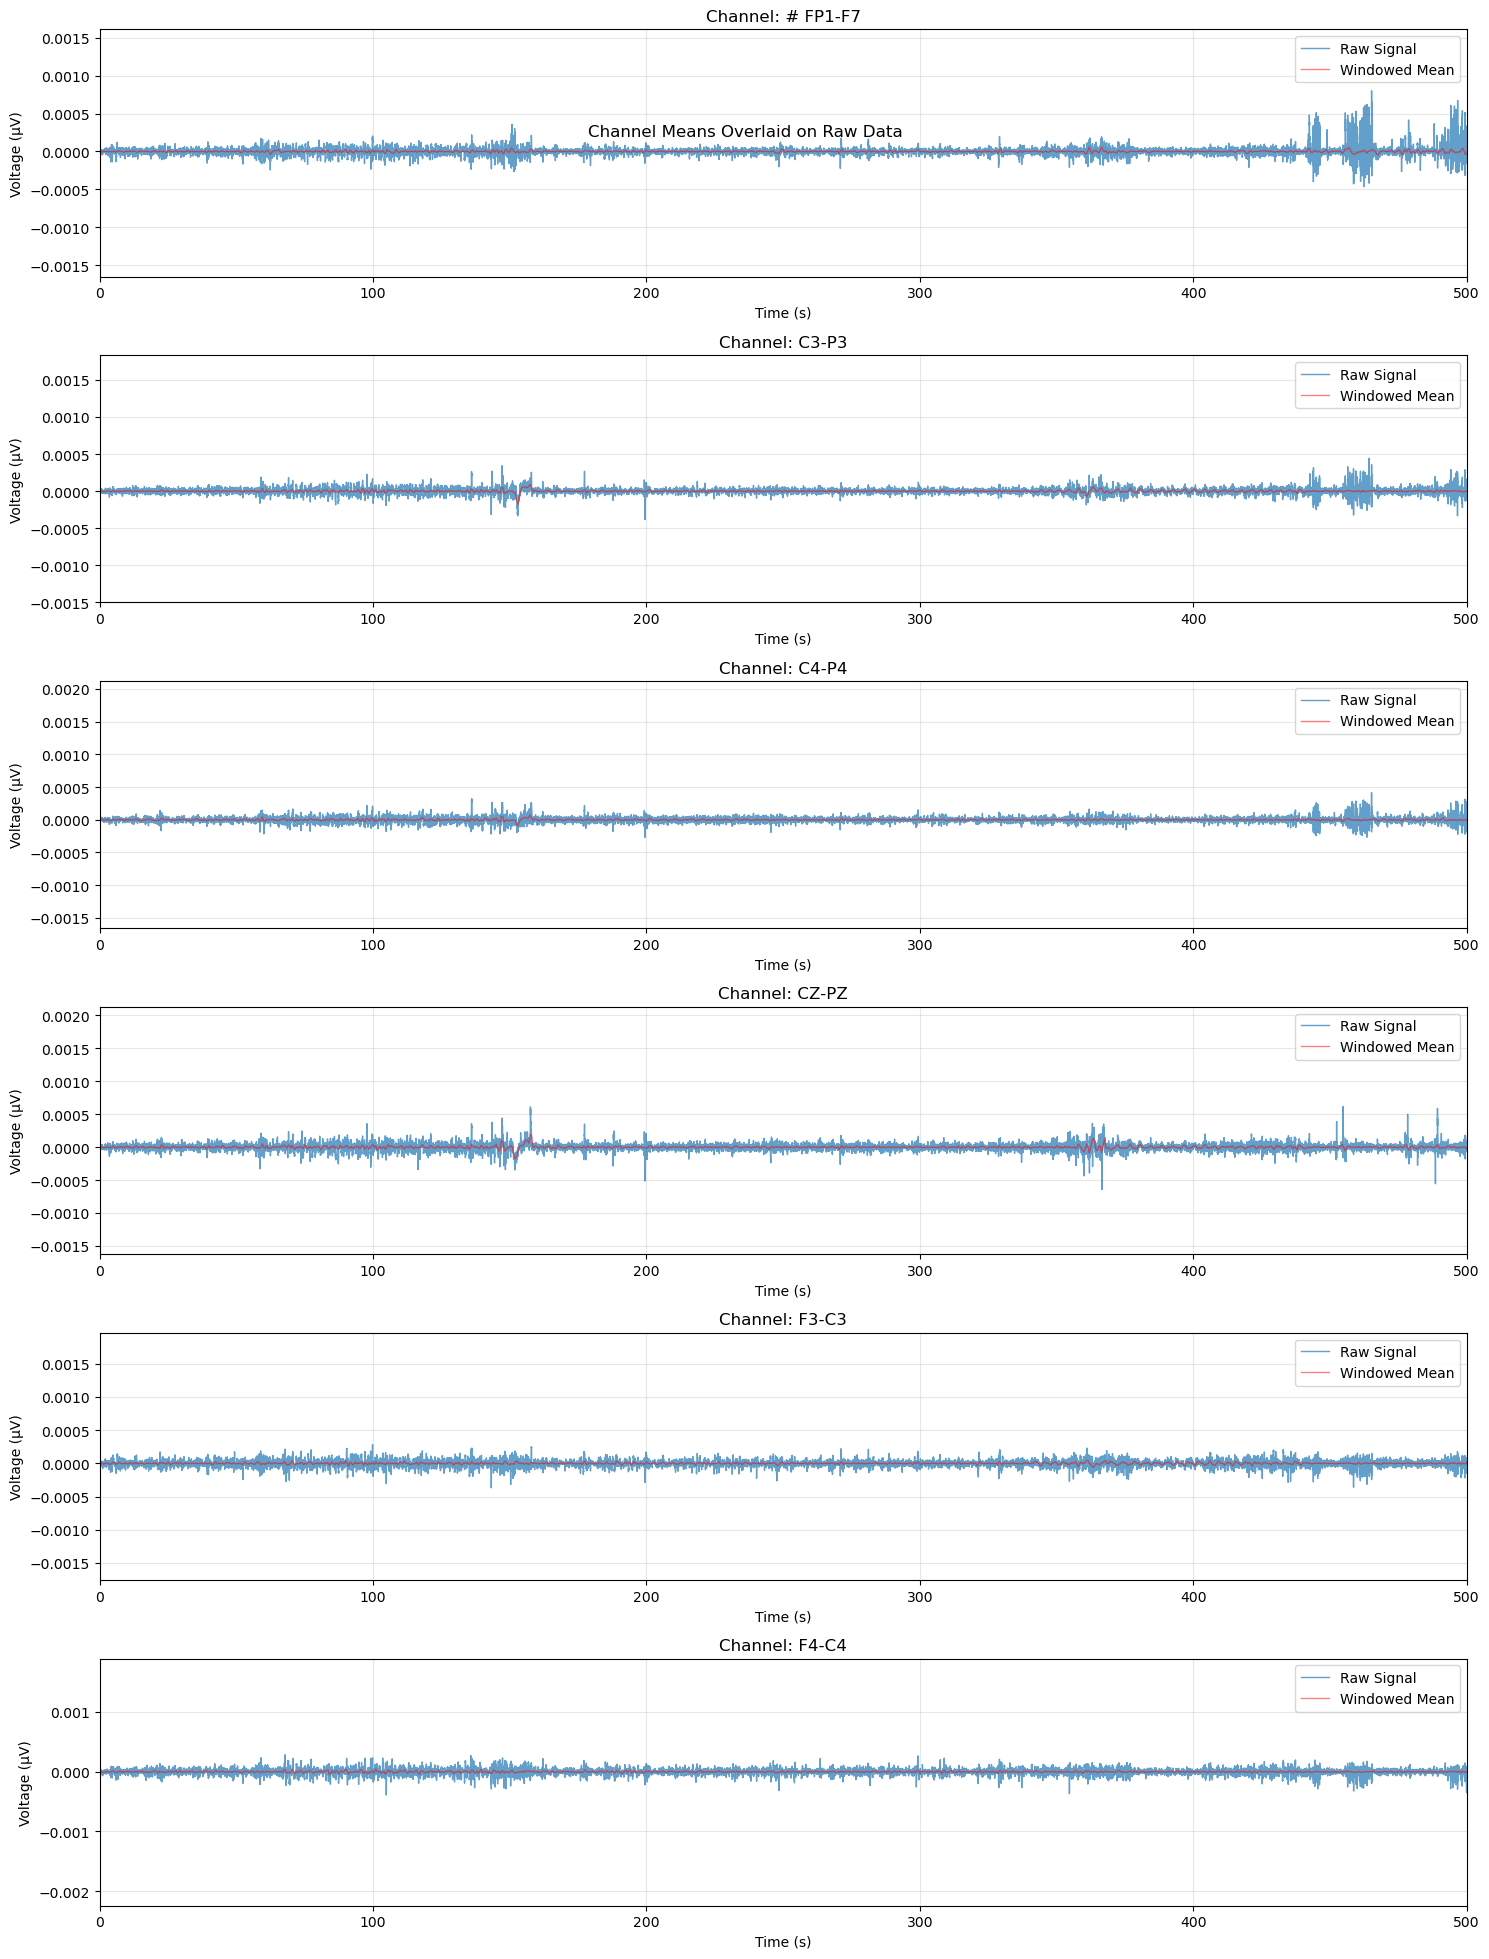

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
raw_data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\chbmit_preprocessed_data.csv')
features_df = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv')

# Parameters
fs = 256  # Sampling frequency
window_size = 256  # 1-second window
step_size = 128  # 50% overlap
channels = [col for col in raw_data.columns if col != 'Outcome']

# Create time axes
raw_time = np.arange(len(raw_data)) / fs  # Original data time axis
feature_time = (np.arange(len(features_df)) * step_size + window_size//2) / fs  # Window centers

# Create figure
plt.figure(figsize=(15, 20))
plt.suptitle('Channel Means Overlaid on Raw Data', y=0.92)

# Plot each channel
for idx, channel in enumerate(channels[:6]):
    ax = plt.subplot(6, 1, idx+1)
    
    # Plot raw data
    ax.plot(raw_time, raw_data[channel], 
            alpha=0.7, 
            linewidth=1, 
            label='Raw Signal')
    
    # Plot windowed means from features
    ax.plot(feature_time, features_df[f'{channel}_mean'], 
            color='red',
            alpha=0.5,
            linewidth=1, 
            label='Windowed Mean')
    
    # Formatting
    ax.set_title(f'Channel: {channel}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (μV)')
    ax.grid(True, alpha=0.3)
    ax.legend()
   
    ax.set_xlim(0, 500)

plt.tight_layout()
plt.savefig('channel_means_overlay.png', dpi=300)
plt.show()


In [43]:
# 2. Mean ± STD Band Visualization
window_stds = []
for start in range(0, len(fp1_f7_raw) - window_size + 1, step_size):
    window = fp1_f7_raw[start:start + window_size]
    window_stds.append(np.std(window))

window_stds = np.array(window_stds)

axs[1].fill_between(window_times, 
                   window_means - window_stds,
                   window_means + window_stds,
                   alpha=0.3, color='g', label='Mean ± STD')
axs[1].plot(window_times, window_means, color='r', linewidth=2)
axs[1].set_title('FP1-F7: Window Means with Standard Deviation Bands')
axs[1].set_ylabel('Voltage (μV)')
axs[1].legend()
axs[1].grid(True)

NameError: name 'fp1_f7_raw' is not defined

In [ ]:
raw_data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\chbmit_preprocessed_data.csv')
features_df = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.7min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished



Cross-Validation Results:
Average Accuracy: 0.9363 (±0.0047)
Average Precision: 0.9475 (±0.0061)
Average Recall: 0.9238 (±0.0091)
Average F1: 0.9355 (±0.0049)
Average ROC AUC: 0.9842 (±0.0015)

Aggregated Evaluation:
              precision    recall  f1-score   support

      Normal       0.93      0.95      0.94      8190
       Event       0.95      0.92      0.94      8192

    accuracy                           0.94     16382
   macro avg       0.94      0.94      0.94     16382
weighted avg       0.94      0.94      0.94     16382



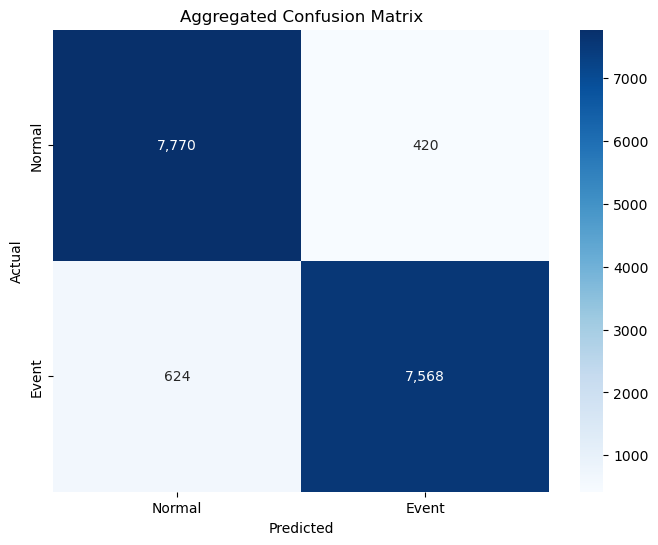

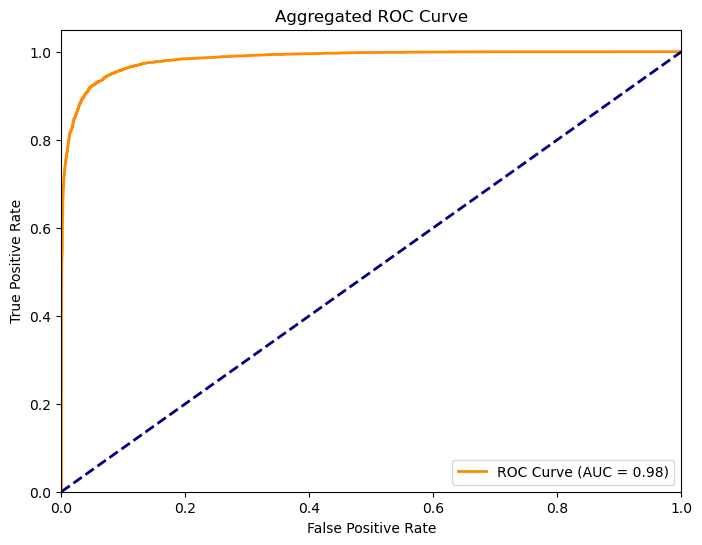

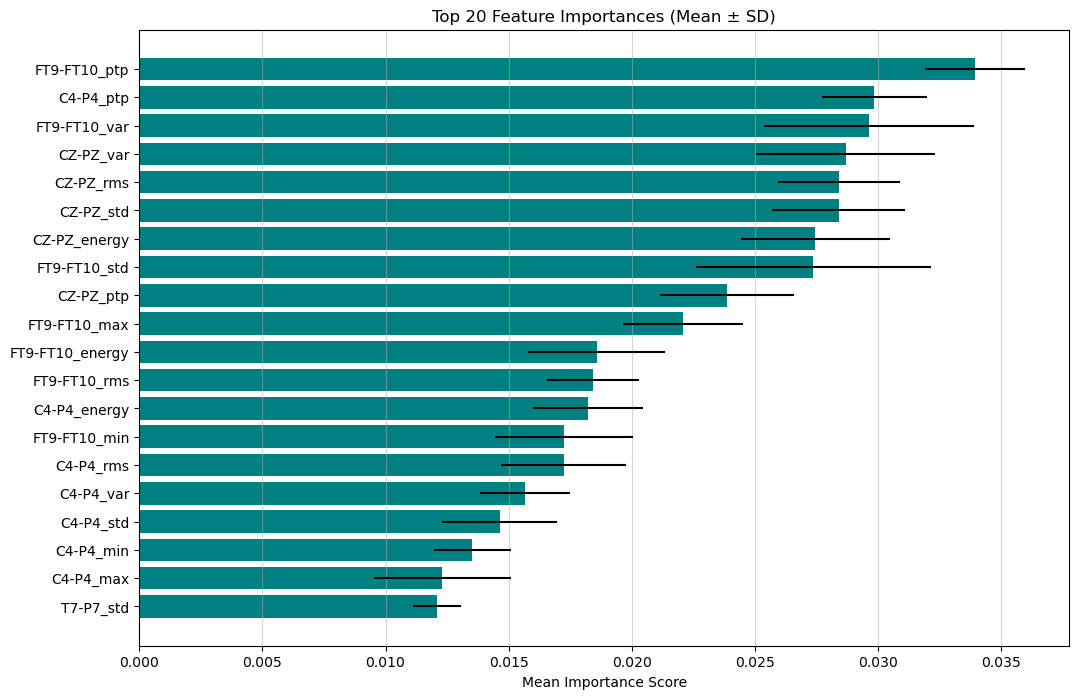

In [54]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

# Load features
df = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv').dropna()

# Configuration
N_SPLITS = 5
N_JOBS = -1
N_ESTIMATORS = 1000
RANDOM_STATE = None

# Prepare data
X = df.drop('target', axis=1)
y = df['target']
features = X.columns.tolist()

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Initialize metrics storage
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': []
}

# Storage for final aggregation
all_y_test = []
all_y_pred = []
all_y_proba = []
feature_importances = []

def process_fold(train_idx, test_idx, X, y):
    """Process one fold with full CPU utilization"""
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Class weights
    classes = np.unique(y_train)
    weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
    weight_dict = {cls: w for cls, w in zip(classes, weights)}
    
    # Model training
    rf = RandomForestClassifier(
        n_estimators=N_ESTIMATORS,
        max_depth=15,
        class_weight=weight_dict,
        n_jobs=N_JOBS,
        verbose=2,
        random_state=RANDOM_STATE,
        criterion='gini'
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]
    
    return {
        'y_test': y_test,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'importances': rf.feature_importances_
    }

# Parallel processing of folds
results = Parallel(n_jobs=min(N_SPLITS, N_JOBS), verbose=10)(
    delayed(process_fold)(train_idx, test_idx, X, y)
    for train_idx, test_idx in skf.split(X, y)
)

# Aggregate results
for result in results:
    all_y_test.extend(result['y_test'])
    all_y_pred.extend(result['y_pred'])
    all_y_proba.extend(result['y_proba'])
    feature_importances.append(result['importances'])
    
    # Calculate fold metrics
    metrics['accuracy'].append(accuracy_score(result['y_test'], result['y_pred']))
    metrics['precision'].append(precision_score(result['y_test'], result['y_pred']))
    metrics['recall'].append(recall_score(result['y_test'], result['y_pred']))
    metrics['f1'].append(f1_score(result['y_test'], result['y_pred']))
    metrics['roc_auc'].append(roc_auc_score(result['y_test'], result['y_proba']))

# Calculate average feature importances
mean_importances = np.mean(feature_importances, axis=0)
std_importances = np.std(feature_importances, axis=0)

# Print metrics
print("\nCross-Validation Results:")
print(f"Average Accuracy: {np.mean(metrics['accuracy']):.4f} (±{np.std(metrics['accuracy']):.4f})")
print(f"Average Precision: {np.mean(metrics['precision']):.4f} (±{np.std(metrics['precision']):.4f})")
print(f"Average Recall: {np.mean(metrics['recall']):.4f} (±{np.std(metrics['recall']):.4f})")
print(f"Average F1: {np.mean(metrics['f1']):.4f} (±{np.std(metrics['f1']):.4f})")
print(f"Average ROC AUC: {np.mean(metrics['roc_auc']):.4f} (±{np.std(metrics['roc_auc']):.4f})")

# Final evaluation on all predictions
print("\nAggregated Evaluation:")
print(classification_report(all_y_test, all_y_pred, target_names=['Normal', 'Event']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_y_test, all_y_pred)
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues',
            xticklabels=['Normal', 'Event'],
            yticklabels=['Normal', 'Event'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Aggregated Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(all_y_test, all_y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc_score(all_y_test, all_y_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Aggregated ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
indices = np.argsort(mean_importances)[-20:]
plt.figure(figsize=(12, 8))
plt.title('Top 20 Feature Importances (Mean ± SD)')
plt.barh(range(len(indices)), mean_importances[indices], xerr=std_importances[indices],
         align='center', color='teal', ecolor='black')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Mean Importance Score')
plt.grid(axis='x', alpha=0.5)
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'distance'}
Best CV AUC: 0.9866

Cross-Validation Metrics:
mean_accuracy     0.938164
mean_precision    0.949888
mean_recall       0.925172
mean_f1           0.937353
mean_roc_auc      0.986563
dtype: float64
std_accuracy     0.001623
std_precision    0.003275
std_recall       0.005174
std_f1           0.001788
std_roc_auc      0.001351
dtype: float64


D:\MOOC.fi\Jupyter\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\MOOC.fi\Jupyter\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      8190
           1       0.82      0.75      0.78      8192

    accuracy                           0.79     16382
   macro avg       0.79      0.79      0.79     16382
weighted avg       0.79      0.79      0.79     16382



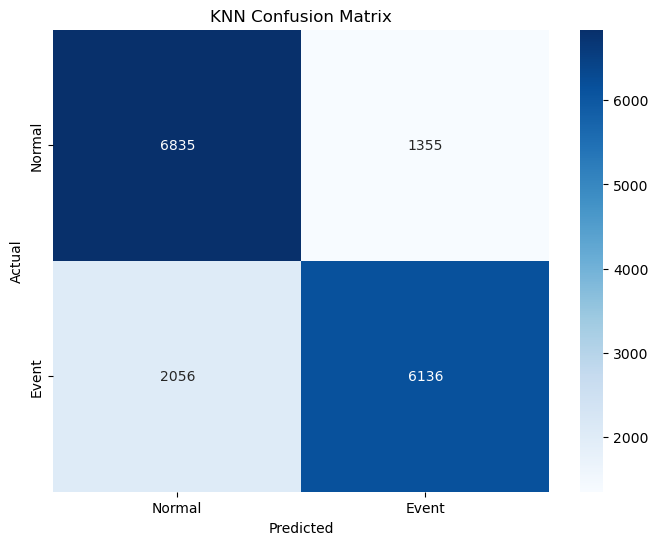

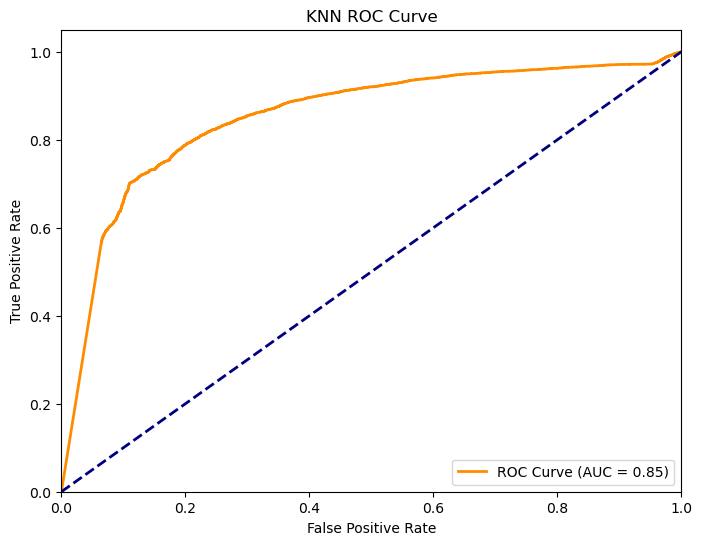

KeyboardInterrupt: 

In [61]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data
df = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv').dropna()
X = df.drop('target', axis=1)
y = df['target']
features = X.columns.tolist()

# Configuration
N_JOBS = -1  # Adjust based on available cores
N_SPLITS = 5
RANDOM_STATE = 0

# Create preprocessing pipeline
scaler = StandardScaler()
knn = KNeighborsClassifier(algorithm='auto', n_jobs=1)
pipe = Pipeline([('scaler', scaler), ('knn', knn)])

# Hyperparameter grid
param_grid = {
    'knn__n_neighbors': [7],
    'knn__weights': ['distance'],
    'knn__p': [2]  # 1: Manhattan, 2: Euclidean
}

# Stratified K-Fold Grid Search
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(pipe, param_grid, cv=skf, scoring='roc_auc',
                           n_jobs=N_JOBS, verbose=2, refit=True)

# Fit model with parallel processing
grid_search.fit(X, y)

# Best model
best_knn = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV AUC: {grid_search.best_score_:.4f}")

# Cross-validated evaluation
def cross_val_metrics(model, X, y, cv):
    metrics = []
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        metrics.append({
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba)
        })
    return pd.DataFrame(metrics)

# Get cross-validation results
cv_results = cross_val_metrics(best_knn, X, y, skf)

# Print metrics
print("\nCross-Validation Metrics:")
print(cv_results.mean().add_prefix('mean_'))
print(cv_results.std().add_prefix('std_'))

# Final evaluation on full data
y_pred = best_knn.predict(X_scaled)
y_proba = best_knn.predict_proba(X_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Event'],
            yticklabels=['Normal', 'Event'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc_score(y, y_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Feature importance via permutation
from sklearn.inspection import permutation_importance

result = permutation_importance(best_knn, X, y, n_repeats=5,
                                random_state=RANDOM_STATE, n_jobs=N_JOBS)

sorted_idx = result.importances_mean.argsort()[-20:]
plt.figure(figsize=(12, 8))
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=X.columns[sorted_idx])
plt.title("Permutation Importances (20 most important)")
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'distance', 'pca__n_components': None, 'pca__whiten': False}
Best CV AUC: 0.9870
Explained variance ratio: 1.000


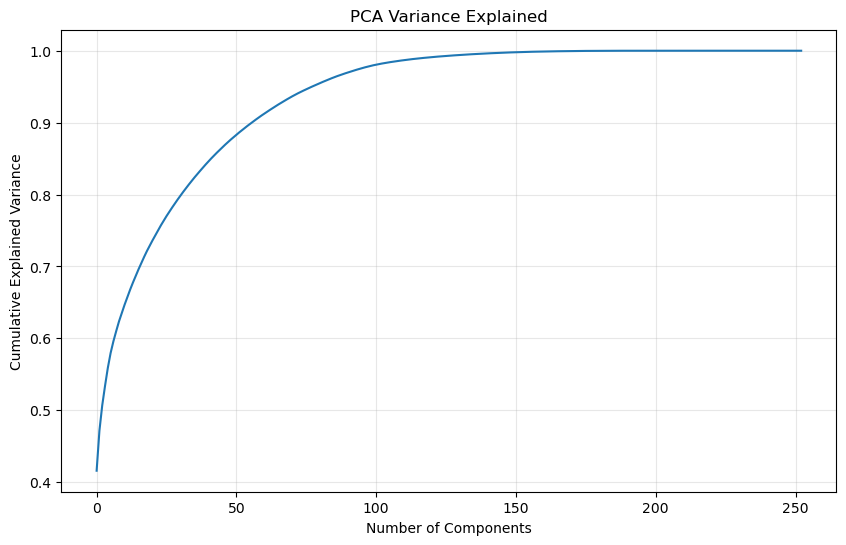


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8190
           1       1.00      1.00      1.00      8192

    accuracy                           1.00     16382
   macro avg       1.00      1.00      1.00     16382
weighted avg       1.00      1.00      1.00     16382



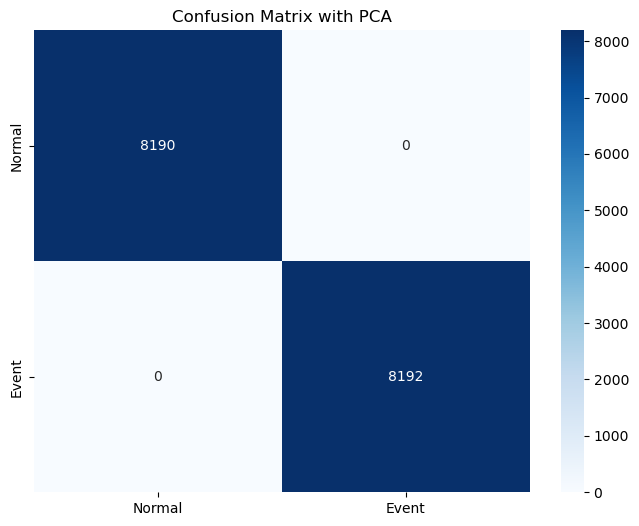

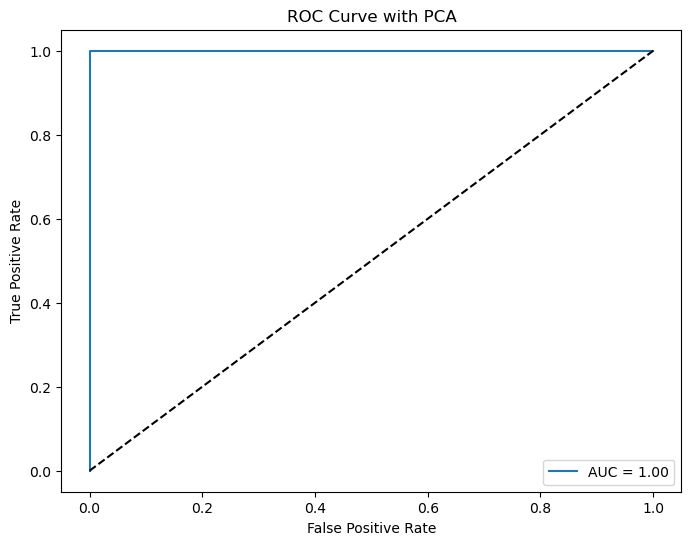

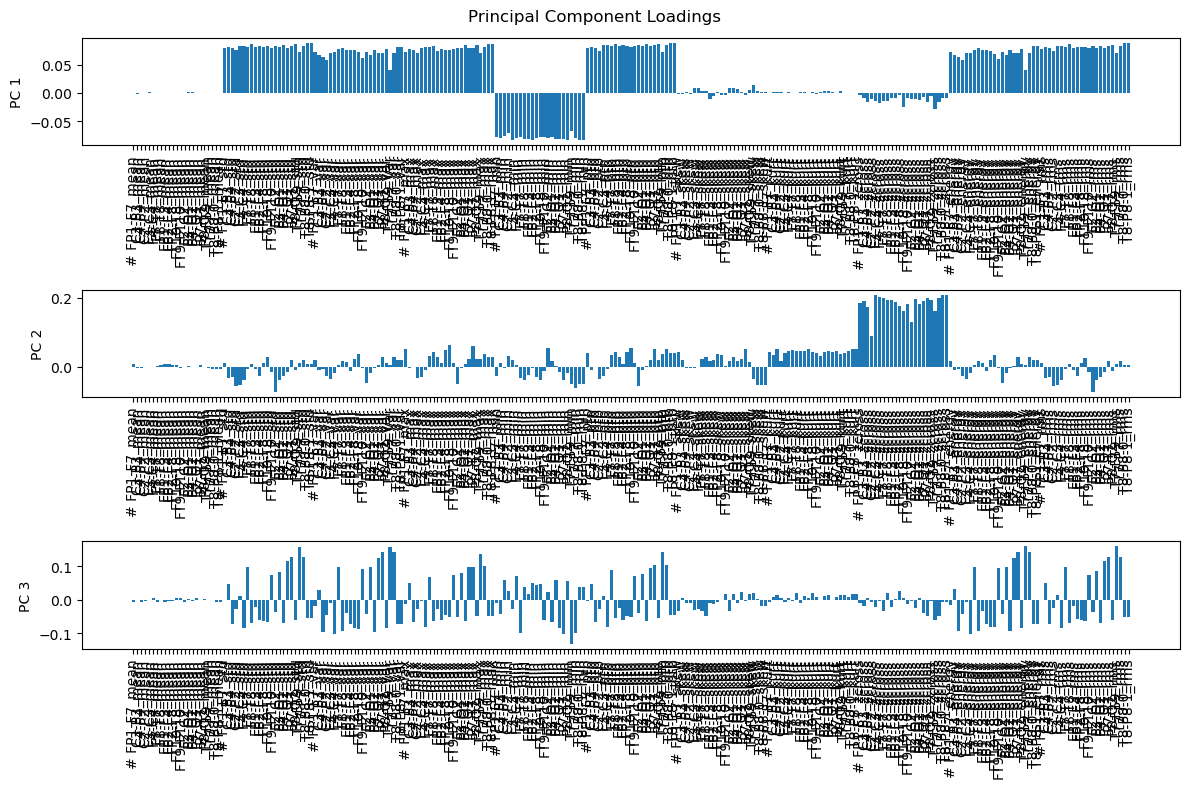

In [63]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, roc_curve, roc_auc_score,
                             confusion_matrix, precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv').dropna()
X = df.drop('target', axis=1)
y = df['target']

# Create pipeline with PCA
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

# Hyperparameter grid
param_grid = {
    'pca__n_components': [0.95, None],  # None keeps all components
    'pca__whiten': [True, False],
    'knn__n_neighbors': [7],
    'knn__weights': ['distance'],
    'knn__p': [2]
}

# Stratified K-Fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search with parallelization
grid_search = GridSearchCV(pipe, param_grid, cv=skf, scoring='roc_auc',
                          n_jobs=-1, verbose=2)
grid_search.fit(X, y)

# Best model analysis
best_pipe = grid_search.best_estimator_
pca = best_pipe.named_steps['pca']
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV AUC: {grid_search.best_score_:.4f}")
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.3f}")

# PCA Visualization
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='tab:blue')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explained')
plt.grid(alpha=0.3)
plt.show()

# Cross-validated metrics
y_pred = grid_search.predict(X)
y_proba = grid_search.predict_proba(X)[:, 1]

print("\nClassification Report:")
print(classification_report(y, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Event'],
            yticklabels=['Normal', 'Event'])
plt.title('Confusion Matrix with PCA')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with PCA')
plt.legend()
plt.show()

# PCA Component Analysis
components = pca.components_
feature_names = X.columns

plt.figure(figsize=(12, 8))
for i in range(3):  # First 3 components
    plt.subplot(3, 1, i+1)
    plt.bar(range(len(feature_names)), components[i], color='tab:blue')
    plt.xticks(range(len(feature_names)), feature_names, rotation=90)
    plt.ylabel(f'PC {i+1}')
plt.suptitle('Principal Component Loadings')
plt.tight_layout()
plt.show()

In [66]:
 !pip install --extra-index-url https://pypi.nvidia.com/ cuml-cu12

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com/
  Using cached cuml_cu12-25.2.1.tar.gz (2.5 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [62 lines of output]
  INFO:wheel-stub:Testing wheel cuml_cu12-25.2.1-cp310-cp310-manylinux_2_28_aarch64.whl against tag cp310-cp310-manylinux_2_28_aarch64
  INFO:wheel-stub:Testing wheel cuml_cu12-25.2.1-cp310-cp310-manylinux_2_28_x86_64.whl against tag cp310-cp310-manylinux_2_28_x86_64
  INFO:wheel-stub:Testing wheel cuml_cu12-25.2.1-cp311-cp311-manylinux_2_28_aarch64.whl against tag cp311-cp311-manylinux_2_28_aarch64
  INFO:wheel-stub:Testing wheel cuml_cu12-25.2.1-cp311-cp311-manylinux_2_28_x86_64.whl against tag cp311-cp311-manylinux_2_28_x86_64
  INFO:wheel-stub:Testing wheel cuml_cu12-25.2.1-cp312-cp312-manylinux_2_28_aarch64.whl against tag cp312-cp312-manylinux_2_28_aarch64
  INFO:wheel-stub:Testing wheel cuml_cu12-25.2.1-cp312-cp312-manylinux_2_28_x86_64.whl against tag cp312-cp312-manylinux_2_28_x86_64
    File "C:\Users\asitk\AppData\Local\Temp\pip-bu

In [64]:
import pandas as pd
import numpy as np
from cuml import SVC
from cuml.model_selection import train_test_split, GridSearchCV
from cuml.preprocessing import StandardScaler
from cuml.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data
df = pd.read_csv('eeg_features_gpu.csv').dropna()
X = df.drop('target', axis=1).values.astype(np.float32)
y = df['target'].values.astype(np.int32)

# Convert to cuDF DataFrame for GPU acceleration
import cudf
X_gpu = cudf.DataFrame(X)
y_gpu = cudf.Series(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_gpu, y_gpu,
    test_size=0.2,
    stratify=y_gpu,
    random_state=42
)

# Create pipeline
scaler = StandardScaler()
svm = SVC(probability=True)

# Hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced']
}

# GPU-accelerated grid search
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # Uses all available GPUs
)

# Fit and predict with GPU
X_train_scaled = scaler.fit_transform(X_train)
grid_search.fit(X_train_scaled, y_train)

# Best model evaluation
best_svm = grid_search.best_estimator_
X_test_scaled = scaler.transform(X_test)
y_pred = best_svm.predict(X_test_scaled)
y_proba = best_svm.predict_proba(X_test_scaled)[:, 1]

# Convert to CPU for sklearn metrics
y_test_cpu = y_test.to_array()
y_pred_cpu = y_pred.to_array()
y_proba_cpu = y_proba.to_array()

# Evaluation metrics
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred_cpu))

print(f"\nROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_cpu, y_pred_cpu)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Event'],
            yticklabels=['Normal', 'Event'])
plt.title('SVM Confusion Matrix (GPU Accelerated)')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_cpu, y_proba_cpu)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'AUC = {roc_auc_score(y_test_cpu, y_proba_cpu):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend()
plt.show()

# Feature Importance (Linear Kernel)
if best_svm.kernel == 'linear':
    importance = best_svm.coef_.to_array().flatten()
    features = df.drop('target', axis=1).columns
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=importance, y=features, palette='viridis')
    plt.title('Feature Importance (Linear SVM Coefficients)')
    plt.xlabel('Coefficient Value')
    plt.show()
else:
    from cuml.inspection import permutation_importance
    result = permutation_importance(
        best_svm, X_test_scaled, y_test,
        n_repeats=10, random_state=42
    )
    
    sorted_idx = result.importances_mean.argsort()[-20:]
    plt.figure(figsize=(12, 8))
    plt.boxplot(result.importances[sorted_idx].T,
                vert=False, labels=features[sorted_idx])
    plt.title("Permutation Importances (20 Most Important)")
    plt.show()

ModuleNotFoundError: No module named 'cuml'